# ANALYSE SUR LE MODELE TARGET + XGBOOST AVEC 11 INPUTS

In [1]:
import pandas as pd
import numpy as np
import panel as pn

import pickle

from sklearn.model_selection import train_test_split

import xgboost as xgb
from xgboost import XGBRegressor

from pandas_profiling import ProfileReport

from pandas.plotting import scatter_matrix



from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

import eli5
from eli5.sklearn import PermutationImportance

from pdpbox import pdp, get_dataset, info_plots

from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay

import shap

import lime
import lime.lime_tabular

In [2]:
path = './data/'

## ANALYSE DES DONNEES TEST DU DEFI (PANDAS PROFILING)

In [24]:
test = pd.read_csv(path+'test_set3.csv')
test.head()

,nb_requete,index,order_requests,city,date,language,mobile,avatar_id,hotel_id,stock,group,brand,parking,pool,children_policy
0,1,0,1,vilnius,21,romanian,0,1,161,46,Boss Western,J.Halliday Inn,1,0,0
1,1,1,1,vilnius,21,romanian,0,1,187,32,Accar Hotels,Marcure,1,1,0
2,1,2,1,vilnius,21,romanian,0,1,279,12,Independant,Independant,1,0,0
3,1,3,1,vilnius,21,romanian,0,1,395,10,Accar Hotels,Ibas,0,0,0
4,1,4,1,vilnius,21,romanian,0,1,488,42,Accar Hotels,Safitel,1,1,1


In [25]:
#On affecte le bon type aux variables qualitatives
test["city"]=pd.Categorical(test["city"],ordered=False)
test["language"]=pd.Categorical(test["language"],ordered=False)
test["group"]=pd.Categorical(test["group"],ordered=False)
test["brand"]=pd.Categorical(test["brand"],ordered=False)

test["mobile"]=pd.Categorical(test["mobile"],ordered=False)
test["parking"]=pd.Categorical(test["parking"],ordered=False)
test["pool"]=pd.Categorical(test["pool"],ordered=False)
test["children_policy"]=pd.Categorical(test["children_policy"],ordered=False)

test["hotel_id"]=pd.Categorical(test["hotel_id"],ordered=False)
test["avatar_id"]=pd.Categorical(test["avatar_id"],ordered=False)

In [26]:
testP = test.drop(columns=["index","order_requests","avatar_id"])

In [27]:
ProfileReport(testP,minimal=True)
#ProfileReport(testP)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [39]:
np.sort(test['date'].unique()) 

array([ 0,  1,  2,  3,  4,  5,  6, 15, 16, 17, 18, 19, 20, 21, 34, 35, 36,
       37, 38, 39, 40])

NB : Nous avons dans un premier temps considéré le nombre de requêtes effectué par l'avatar comme une feature de notre modèle, car nous pensions que l'historique des demandes aurait de l'importance sur le prix - cela correspond à la variable nb_requete et au modèle à 12 inputs.
Nous avons ensuite abandonné cette feature car nous nous sommes rendu compte qu'elle avait une influence négligeable par rapport aux autres features, en utilisant la Permutation Importance sur ce modèle.

Le Panda Profiling révèle pour le dataset du Défi :
* un nombre de requêtes entre 1 et 3 - nous avons donc limité à 3 le nombre de requêtes possible par avatar.
* des dates qui ne prennent pas toutes les valeurs dans l'intervalle [ 0 ; 44 ] - la stratégie pour notre choix de dates à requêter n'a pas été de coller à cette distribution, nous avons en fait essayé de réduire la MSE.
* une distribution des villes et une distribution des langues auxquelles nous avons essayé de coller pour nos dernières requêtes.
* autant de requêtes avec un mobile ou sans mobile - nous avons fait de même pour nos requêtes.

## ANALYSE DES DONNEES REQUEST (PANDAS PROFILING)

In [28]:
data = pd.read_csv(path+'new_result_requetes.csv')
data.head()

,order_requests,nb_requete,hotel_id,price,stock,city,date,language,mobile,avatar_id,group,brand,parking,pool,children_policy
0,1,1,859,134,58,valletta,30,portuguese,0,65736,Independant,Independant,0,0,0
1,1,1,719,155,97,valletta,30,portuguese,0,65736,Yin Yang,Royal Lotus,0,0,0
2,1,1,160,94,21,valletta,30,portuguese,0,65736,Independant,Independant,1,0,0
3,1,1,504,158,74,valletta,30,portuguese,0,65736,Morriott International,Morriot,0,0,0
4,1,1,295,73,21,valletta,30,portuguese,0,65736,Yin Yang,8 Premium,0,0,0


In [29]:
#On affecte le bon type aux variables qualitatives
data["city"]=pd.Categorical(data["city"],ordered=False)
data["language"]=pd.Categorical(data["language"],ordered=False)
data["group"]=pd.Categorical(data["group"],ordered=False)
data["brand"]=pd.Categorical(data["brand"],ordered=False)

data["mobile"]=pd.Categorical(data["mobile"],ordered=False)
data["parking"]=pd.Categorical(data["parking"],ordered=False)
data["pool"]=pd.Categorical(data["pool"],ordered=False)
data["children_policy"]=pd.Categorical(data["children_policy"],ordered=False)

data["hotel_id"]=pd.Categorical(data["hotel_id"],ordered=False)
data["avatar_id"]=pd.Categorical(data["avatar_id"],ordered=False)

data["price"]=pd.DataFrame(data["price"], dtype=float)

In [30]:
dataP = data.drop(columns=["order_requests","avatar_id"])

In [40]:
#ProfileReport(dataP,minimal=True)
ProfileReport(dataP)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Les graphiques des Interactions et des Corrélations de Panda Profiling, redonnés ci-dessous, révèlent pour notre dataset :
* une corrélation = 0.2 environ entre le prix et le stock avec un prix plus élevé quand le stock est petit. Passé un stock de 50 chambres disponibles, on observe peu de variation du prix.
* une corrélation = -0.2 environ entre le prix et la date avec un prix plus élevé quand la date est proche. Passé 20 jours, on observe peu de variation du prix. 
* une corrélation = 0.8 forte entre le stock et la date, avec un stock plus petit quand la date est proche.

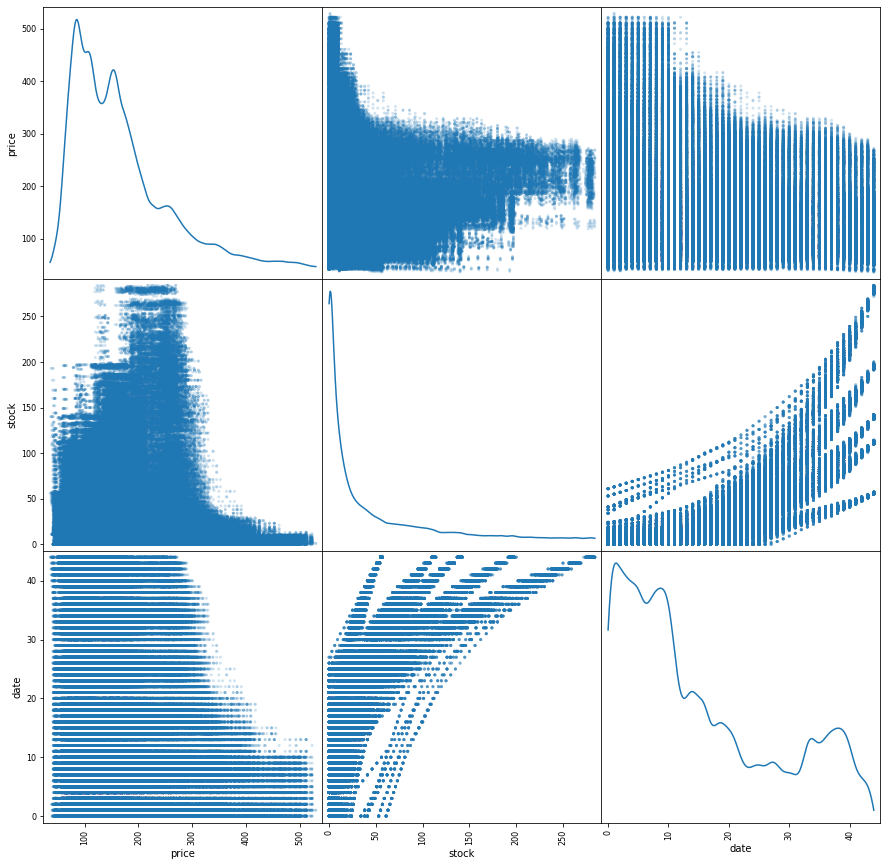

In [49]:
# scatter plot matrix
#scatter_matrix(dataP, alpha=0.2, figsize=(15, 15), diagonal='kde')
scatter_matrix(data[["price","stock","date"]], alpha=0.2, figsize=(15, 15), diagonal='kde')
plt.show()

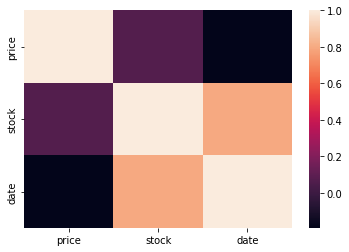

In [50]:
# correlation matrix
#correlation_mat = dataP.corr()
correlation_mat = data[["price","stock","date"]].corr()
import seaborn as sns
sns.heatmap(correlation_mat, annot = False)

plt.show()

In [32]:
X = data[["date","stock","city","language","mobile","hotel_id","group","brand","parking","pool","children_policy"]]
Y = data[["price"]]

## INTERPRETABILITE

### Preprocessing

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [8]:
feature_names = X_test.columns
feature_names

Index(['date', 'stock', 'city', 'language', 'mobile', 'hotel_id', 'group',
       'brand', 'parking', 'pool', 'children_policy'],
      dtype='object')

In [9]:
#model = pickle.load(open('./XGB11_Target_model_saved_Final.pkl', 'rb'))
model = pickle.load(open('./XGB11CT_model_saved_Final.sav', 'rb'))

In [10]:
model_name = "XGBoost"

In [11]:
model

Pipeline(steps=[('Cat_encoder',
                 TargetEncoder(cols=['city', 'language', 'mobile', 'hotel_id',
                                     'group', 'brand', 'parking', 'pool',
                                     'children_policy'])),
                ('Standard_scaler', StandardScaler()),
                ('Boosting',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_catego...
                              feature_types=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_threshold=64, max_cat_to_onehot=4,
                              max_delta_step=0, max_depth=10, max_leaves=0,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=3000,
                              n_jobs=0, num_parallel_tree=1, predictor='auto',
                              random_state=0, ...))])

### Permutation Importance

In [12]:
permutation_impor = PermutationImportance(model, random_state=42).fit(X_test, y_test)

In [13]:
features_importance = {'Feature_name':feature_names, 'Importance':permutation_impor.feature_importances_}  
features_importance = pd.DataFrame(features_importance) 
features_importance = features_importance.sort_values(['Importance'], ascending=False)

Text(0.5, 1.0, 'XGBoost')

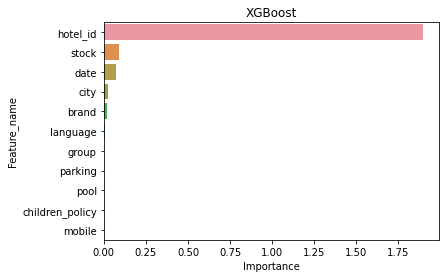

In [14]:
plt.figure()
ax = sns.barplot(x="Importance", y="Feature_name", data=features_importance)
plt.title(model_name)

On observe que la feature hotel_id est de plus loin la plus influente sur le modèle.
Cela est cohérent avec le fait que le prix varie beaucoup d'un hotel à l'autre, même à prestations égales (parking, pool, children_policy) et dans la même ville.

On affiche ci-dessous le même graphique à partir de la seconde feature.

Text(0.5, 1.0, 'XGBoost')

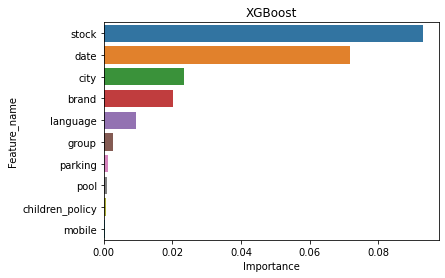

In [15]:
#sans l'hotel_id
plt.figure()
ax = sns.barplot(x="Importance", y="Feature_name", data=features_importance[1:])
plt.title(model_name)

Les features stock et date ont également une influence importante sur le modèle. Viennent ensuite la city, le brand et la langue. Le reste des features ont une influence négligeable. Cela justifie le fait que nous avons entrainé un modèle utilisant seulement les sept premières features par ordre d'importance.

### PDP and ICE plots

In [ ]:
#top_features = features_importance.Feature_name[:7].values
#for i, feature in enumerate(top_features, 1):
#    pdp_feat = pdp.pdp_isolate(model=model, dataset=X_test, model_features=feature_names, feature=feature)
#    pdp.pdp_plot(pdp_feat, feature, plot_lines=True, frac_to_plot=0.1, figsize=(10,5))

In [ ]:
#features_to_plot = ['stock','hotel_id']
#inter1 = pdp.pdp_interact(model=model, dataset=X_test, model_features=feature_names, features=features_to_plot)

#pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
#plt.show()

In [ ]:
#features_to_plot = ['stock','price']
#inter1 = pdp.pdp_interact(model=model, dataset=X_test, model_features=feature_names, features=features_to_plot)

#pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
#plt.show()

In [ ]:
#features_to_plot = ['date','price']
#inter1 = pdp.pdp_interact(model=model, dataset=X_test, model_features=feature_names, features=features_to_plot)

#pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
#plt.show()

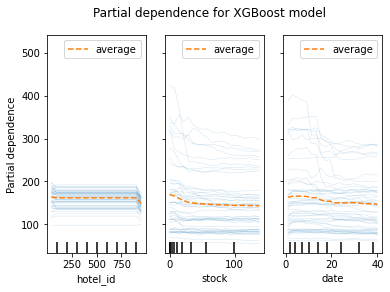

In [16]:
top_3_features = features_importance.Feature_name[:3].values
display = PartialDependenceDisplay.from_estimator(
    model,
    X_test,
    top_3_features,
    kind="both",
    subsample=50,
    n_jobs=3,
    n_cols=3,
    grid_resolution=20,
    random_state=42,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"}
)
display.figure_.suptitle(f"Partial dependence for {model_name} model")
display.figure_.subplots_adjust(hspace=0.3)

Ces graphiques sont utilisés pour visualiser l'effet d'une feature sur le modèle (effet marginal). En abscisse on retrouve les valeurs de la feature, en ordonnées les prix moyens associés à cette feature fixée en faisant varier les autres features.

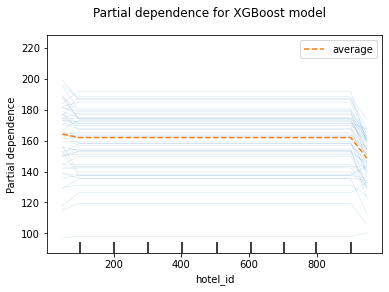

In [19]:
top_features = features_importance.Feature_name[:1].values
display = PartialDependenceDisplay.from_estimator(
    model,
    X_test,
    top_features,
    kind="both",
    subsample=50,
    n_jobs=1,
    n_cols=1,
    grid_resolution=20,
    random_state=42,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"}
)
display.figure_.suptitle(f"Partial dependence for {model_name} model")
display.figure_.subplots_adjust(hspace=0.3)

On observe pour l'hotel_id un graphique de dépendance partielle horizontal, ce qui voudrait dire que cette feature n'a pas d'effet significatif sur la prédiction du modèle. Cela peut sembler contradictoire avec les résultats de la Permutation Importance qui indiquent qu'hotel_id est la feature la plus importante.

En fait, cela peut être le cas pour une feature si celle-ci est une combinaison des autres features. On en conclut que c'est le cas ici et que finalement, on aurait pu retirer cette feature du modèle...

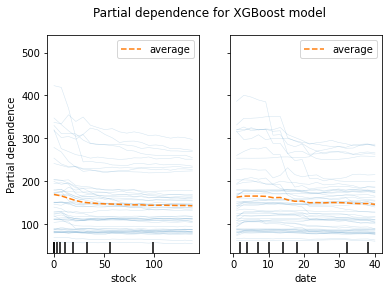

In [22]:
top_features = features_importance.Feature_name[1:3].values
display = PartialDependenceDisplay.from_estimator(
    model,
    X_test,
    top_features,
    kind="both",
    subsample=50,
    n_jobs=2,
    n_cols=2,
    grid_resolution=20,
    random_state=42,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"}
)
display.figure_.suptitle(f"Partial dependence for {model_name} model")
display.figure_.subplots_adjust(hspace=0.3)

On observe une diminution du prix lorsque le stock et la date augmentent, ce qui est cohérent.
Par ailleurs, on note une grande variabilité du prix pour des stocks et des dates faibles, on peut donc penser que le modèle commettra des erreurs plus importantes dans ce cas.

In [ ]:
top_features = features_importance.Feature_name[3:6].values
display = PartialDependenceDisplay.from_estimator(
    model,
    X_test,
    top_features,
    kind="both",
    subsample=50,
    n_jobs=3,
    n_cols=3,
    grid_resolution=20,
    random_state=42,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"}
)
display.figure_.suptitle(f"Partial dependence for {model_name} model")
display.figure_.subplots_adjust(hspace=0.3)

### SHAP

In [33]:
shap.initjs() #needed to plot results directly on the notebook

idx = 1 # index of the instance we want to explain

explainer = shap.KernelExplainer(model.predict, X_test)

Provided model function fails when applied to the provided data set.


KeyError: 'city'

In [ ]:
#shap_values = explainer.shap_values(X_test.iloc[0,:])
#shap.force_plot(explainer.expected_value, shap_values, X_test.iloc[0,:])

#To speed up we just compute the shap values for 50 exemples
shap_values = explainer.shap_values(X_test.iloc[0:50,:])
shap.summary_plot(shap_values, X_test.iloc[0:50,:])

### LIME

In [38]:
index = 0
explainer = lime.lime_tabular.LimeTabularExplainer(X_test.values, feature_names=feature_names, mode="regression")
exp = explainer.explain_instance(X_test.iloc[index], model.predict, num_features=7, top_labels=1)

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [ ]:
exp.show_in_notebook(show_table=True, show_all=True)